In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 13:38:43 2023

@author: vincent chouinard
"""
import os
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.filters import threshold_local
from PIL import Image
import imageio
import sys
import imageio.v2 as imageio
from PyQt5.QtWidgets import QFileDialog, QApplication
import tifffile
#import imageio
module_path = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis'
sys.path.insert(1,module_path)
from motion_correction_caiman import *
from WFmovie import WFmovie
from WFmovie import create_channel
from WFmovie import regress_timeseries
from WFmovie import convert_to_hb

module_path_chouine = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis/Chouine'
sys.path.insert(2, module_path_chouine)
from MIFFE import *

2023-07-18 16:01:07.213852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Choosing data folder to analyse

In [2]:
#folderpath= search_path()
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_21fev"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_28fev"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M35"
folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_7juin"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M32_13juin"

### Create_movie arguments (data_path, channels) and kwargs example:
data_path: /Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_28fev 
stim_path: True
channels: ['green']
channels_exist: False
binning: False
normalize: False
gaussian_filter: False
gaussian_std: 1
temp_med_filter: False
temp_med_width: 3
substract_background: False
background_path: None


If needed, all infos are now in MIFFE.py situated in Widefield-Imaging-analysis/Chouine

In [3]:
channel = ['red']
movies = create_movies(folderpath, channels = channel, channels_exist = True, stim_path = True, memmap=True)
movie = movies[0]

data_path: /Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_7juin
stim_path: True
channels: ['red']
channels_exist: True
binning: False
normalize: False
gaussian_filter: False
gaussian_std: 1
temp_med_filter: False
temp_med_width: 3
substract_background: False
background_path: None


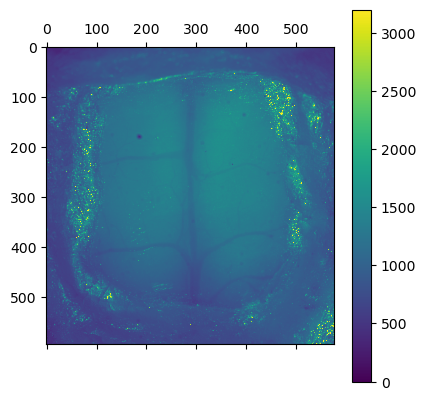

In [4]:
plt.matshow(movie.data[124,:,:])
plt.clim(0,3200)
plt.colorbar()

### Generate data folder for corrections, .tif and numpy-corrected files (should be used only if not already done)

In [4]:
corrected_exists = False

if not corrected_exists:
    generate_data_folder(movie, folderpath, channel, tif = True, CaImAn = True, numpy = True)

Searching directory for uncorrected data in /Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_7juin/Correction...
Calcium imaging data to correct: ['CVR_M35_7juin_red_movie.tif']
Beginning motion correction...
Correcting CVR_M35_7juin_red_movie.tif...


2023-07-18 16:02:23.034772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 16:02:23.034755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 16:02:23.034834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_7juin/Correction/CVR_M35_7juin_red_movie_els__d1_616_d2_491_d3_1_order_F_frames_1890.mmap


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/it]


Done!


## If you want corrected version to replace movie, corrected = True

In [9]:
corrected = True
npy_movie_filename = '/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_7juin/Correction/corrected_CVR_M35_7juin_green_movie.npy'
if corrected:
    npy_movie = np.load(npy_movie_filename)
    movie.data[:] = npy_movie[:]
    del npy_movie

### Here, we generate the average response of the movie.

In [7]:
%matplotlib qt
# add arg to select CROP if needed.
# Ok, so preStim, postStim are in seconds and stim is 10 seconds, so the number of time frames of
# average_response_frames's number of timeframes is:     movie.freq x (preStim + Stim + postStim)
stimchannel = 1


frames = movie.average_response(stim_channel = stimchannel, preStim = 10, postStim = 40)
stim = np.transpose(movie.stim[:,stimchannel-1])

/opt/anaconda3/envs/wia/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
/opt/anaconda3/envs/wia/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide


ValueError: operands could not be broadcast together with shapes (555,596,577) (0,596,577) 

In [14]:
plt.plot(movie.stim[:,0])

In [11]:
%matplotlib inline

plt.plot(stim)
plt.show()

NameError: name 'stim' is not defined

### There's a bunch of animation functions here.

In [10]:
def animate_frames(frames, framerate, vmin, vmax):
    """
    Animates a list of 2D numpy arrays (frames) using matplotlib.

    Parameters:
        - frames (list of 2D numpy arrays): the list of frames to animate
        - framerate (int): the framerate at which to display the animation

    Returns:
        - anim (FuncAnimation object): the animation object
    """    
    
    # Determine the dimensions of the frames
    nframes, height, width = frames.shape

    # Create a figure and axis to display the animation
    fig, ax = plt.subplots()
    

    # Set the initial plot to be the first frame
    im = ax.imshow(frames[0], vmin=vmin, vmax=vmax, cmap='coolwarm')
    fig.colorbar(im)

    # Define the function to animate the plot
    def animate(i):
        im.set_array(frames[i])
        return [im]

    # Create the animation object
    anim = animation.FuncAnimation(fig, animate, frames=nframes, interval=1000/framerate, blit=True)

    return anim

In [11]:
%matplotlib qt

# Animate the frames
anim = animate_frames(frames, movie.freq*3, 0.92, 1.03)

# Display the animation
plt.show()

NameError: name 'frames' is not defined

In [11]:
def save_array_as_gif(video_array, data_dir, gif_name, framerate, intensity_range = (None, None), delete_existing_gif = False):
    """
    Save a 3D NumPy array representing a video as a GIF file.

    Parameters:
    video_array (numpy.ndarray): 3D NumPy array representing the video.
    filename (str): Name of the output GIF file.

    Returns:
    None
    """

    # Normalize the pixel values to the range [0, 255]
    minimum = np.min(video_array)
    maximum = np.max(video_array)
    
    if intensity_range[0] != None:
        minimum = intensity_range[0]
        maximum = intensity_range[1]
        
    video_array = (video_array - minimum) / (maximum - minimum) * 255

    # Convert the pixel values to unsigned 8-bit integers
    video_array = video_array.astype(np.uint8)

    # Creates 'Gifs' folder in data if it does not exist yet.
    output_dir = os.path.join(data_dir, "Gifs")
    os.makedirs(output_dir, exist_ok=True)
    
    # Creates gif_path and stops process if gif with gif_name already exists in output_dir
    gif_path = os.path.join(output_dir, gif_name)
    
    if delete_existing_gif:
        os.remove(gif_path)
        
    if os.path.isfile(gif_path):
        print(f"File {gif_name} already exists in directory {output_dir}")
        return
    
    #Shows
    print('Created GIF path and name: ', gif_path)
    
    
    # --------------------------------
    # Use imageio to save the array as a GIF file
    imageio.mimsave(gif_path, video_array, fps = framerate)

In [12]:
gif_frames = frames
# gif_name = "CVR_M35_21fev.gif"
datapath = folderpath          # Same as the 3rd cell because folderpath is actually the path of the data
save_array_as_gif(gif_frames, folderpath, gif_name, 12, intensity_range = (0.8, 1.3), delete_existing_gif = False)

NameError: name 'gif_name' is not defined

In [12]:
# Dont forget to activate matplotlib qt if a gif is needed

def intensity_histogram(video_array, framerate = 10, intensity_range = (None, None), animate_histogram=False):
    
    if video_array.ndim == 2:
        pixels = video_array.ravel()

        pmin = np.min(pixels)
        pmax = np.max(pixels)
        
        hist, bins = np.histogram(pixels, bins=256, range=(pmin,pmax))
    
        plt.semilogy(bins[:-1], hist)
        plt.show()
        return None
    
    if video_array.ndim == 3:
        
        pmin = np.min(video_array)
        pmax = np.max(video_array)
        
        if intensity_range[0] != None:
            pmin = intensity_range[0]
            pmax = intensity_range[1]

            
        # Measure max(histograms) to have y to scale
        hist_max = 0
        for i in range(video_array.shape[0]):
            # Get the current frame
            pixels = video_array[i].ravel()

            # Calculate the histogram
            hist, bins = np.histogram(pixels, bins=256, range=(pmin, pmax))
            
            if np.max(hist) > hist_max:
                hist_max = np.max(hist)
        
        # Create a figure and axis to display the animation
        fig, ax = plt.subplots()
        ax.semilogy()
        ax.set_xlim([pmin, pmax])
        ax.set_ylim([0, hist_max])
        ax.set_ylabel('Logarithmic scale')
        ax.set_xlabel('Intensity of pixel relative to its mean response over time')
        ax.set_title("Intensity histogram of mean response", fontweight='bold')
        
        
        # Define the function to animate the plot
        def animate(i):
            # Get the current frame
            pixels = video_array[i].ravel()

            # Calculate the histogram
            hist, bins = np.histogram(pixels, bins=256, range=(pmin, pmax))

            # Plot the histogram
            ax.clear()
            
            ax.semilogy(bins[:-1], hist, color='black')
            return [ax]

        # Create the animation object
        nframes = video_array.shape[0]
        anim = animation.FuncAnimation(fig, animate, frames=nframes, interval=500/framerate, blit=True)

        return anim
    
# Can output an animation of histogram over every frame if "video_array" is ndim=3
intensity_histogram(frames, intensity_range = (0.9,1.1))

NameError: name 'frames' is not defined

In [14]:
def animate_frames_with_histogram(frames, framerate=10, intensity_range=(None,None)):
    """
    Animates a list of 2D numpy arrays (frames) using matplotlib and displays an intensity histogram
    of the first frame alongside the animation.

    Parameters:
        - frames (list of 2D numpy arrays): the list of frames to animate
        - framerate (int): the framerate at which to display the animation
        - vmin (int): the minimum pixel value to display in the animation
        - vmax (int): the maximum pixel value to display in the animation
        - intensity_range (tuple): a tuple specifying the minimum and maximum pixel values to include in the histogram

    Returns:
        - anim (FuncAnimation object): the animation object
    """
    
    # Determine the dimensions of the frames
    nframes, height, width = frames.shape

    # Create a figure and axes to display the animation and histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Set the initial plot to be the first frame
    im = ax1.imshow(frames[0], vmin=intensity_range[0], vmax=intensity_range[1], cmap='coolwarm')

    # Calculate the histogram of the first frame and plot it
    pixels = frames[0].ravel()
    pmin = np.min(pixels)
    pmax = np.max(pixels)
    if intensity_range:
        pmin = intensity_range[0]
        pmax = intensity_range[1]
    hist, bins = np.histogram(pixels, bins=256, range=(pmin, pmax))
    
    # Set
    ax2.semilogy()
    ax2.plot(bins[:-1], hist, color='black')
    ax1.set_title('CVR mean response', fontweight='bold')
    ax2.set_title('Mean response histogram of every pixel', fontweight='bold')

    # Define the function to animate the plot and update the histogram
    def animate(i):
        im.set_array(frames[i])
        pixels = frames[i].ravel()
        hist, bins = np.histogram(pixels, bins=256, range=(pmin, pmax))
        ax2.clear()
        ax2.plot(bins[:-1], hist, color='black')
        return [im, ax2]

    # Create the animation object
    anim = animation.FuncAnimation(fig, animate, frames=nframes, interval=1000/framerate, blit=True, repeat = False)

    return anim

In [15]:
animate_frames_with_histogram(frames, intensity_range = (0.92, 1.02))

In [16]:
# creates timeseries matrix to add every pixel timeserie sequentially in rows.
t, M, N = frames.shape
transposed_frames = np.transpose(frames, (1,2,0))
timeseries = np.reshape(transposed_frames, (-1, t))
timeseries.shape

(296449, 480)

In [17]:
def stack_some_timeseries(N, data, jump, normalize = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the stacked timeseries with white color
    count=0
    for i in tqdm(range(np.uint8(N/jump))):
        timeserie = data[jump*i]
        if normalize:
            data_min = np.min(timeserie)
            data_max = np.max(timeserie)
            timeserie = 2*((timeserie - data_min)/(data_max-data_min) - 1)
        plt.plot(timeserie+count)
        count += 2

    # Show the plot
    plt.show()

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 747.49it/s]


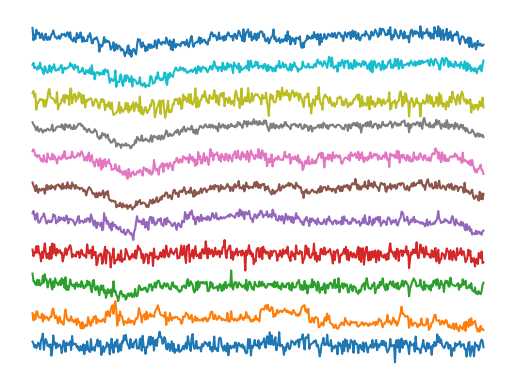

In [18]:
%matplotlib inline

n_timeseries = timeseries.shape[0]
n_pixels = 11
stack_some_timeseries(n_timeseries, timeseries, int(n_timeseries/n_pixels), normalize = True)

In [19]:
minimums = timeseries.min(axis=1)
maximums = timeseries.max(axis=1)

In [20]:
min_matrix = np.reshape(minimums, (M,-1))
max_matrix = np.reshape(maximums, (M,-1))

# Holy shit j'ai un résultat juste en bas, c'est une mean map

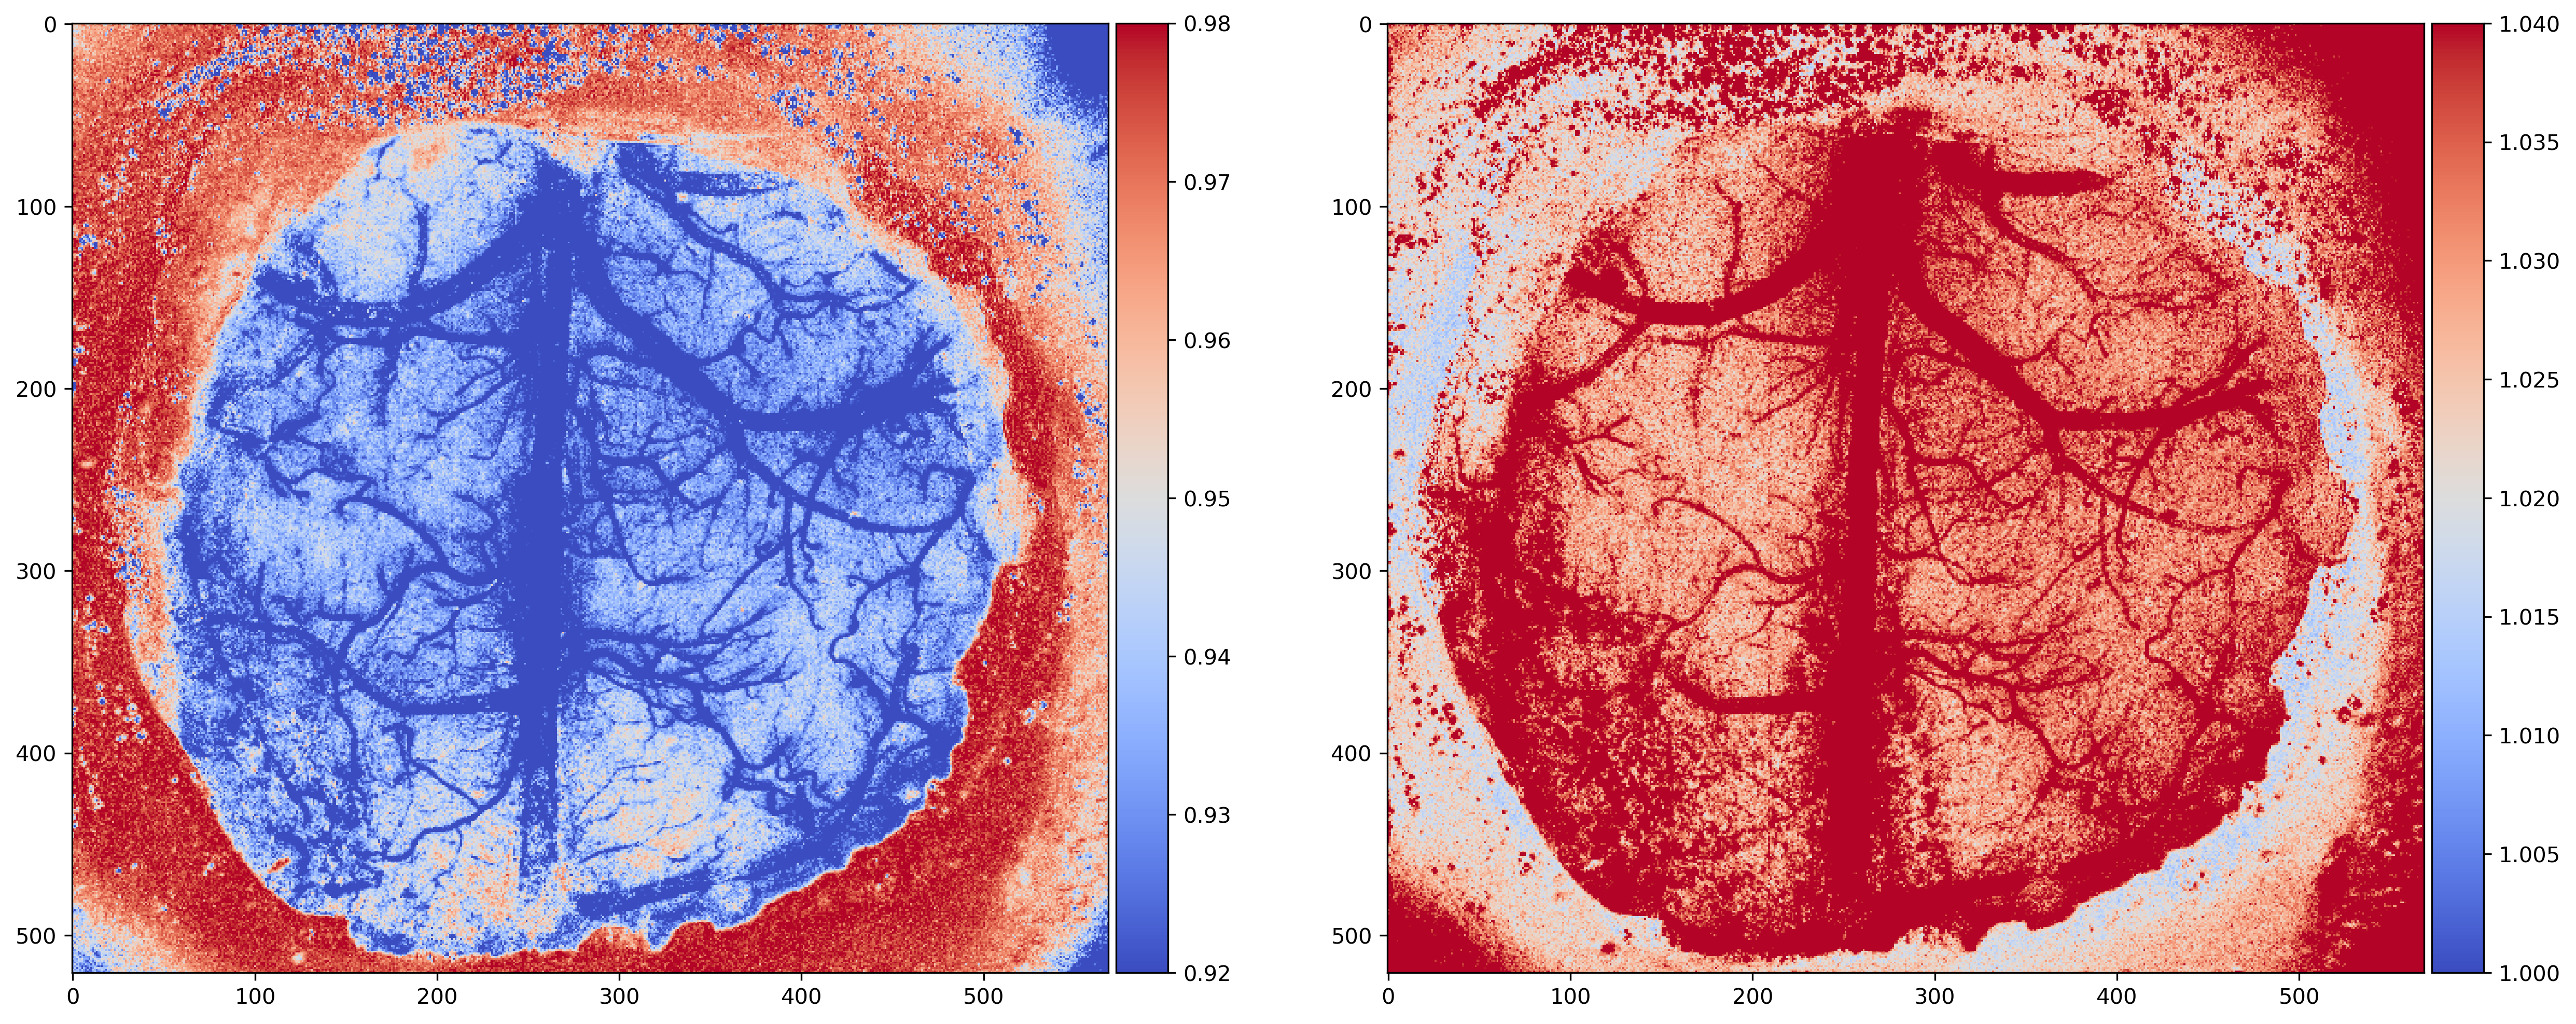

In [21]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(20,10))
im1 = ax[0].imshow(min_matrix, vmin=0.92, vmax=0.98, interpolation="none", cmap='coolwarm')
im2 = ax[1].imshow(max_matrix, vmin=1.00, vmax=1.04, interpolation="none", cmap='coolwarm')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.show()

## Binary manipulations to isolate vasculature

In [22]:
mean_reflectance = np.mean(movie.data, axis=0)

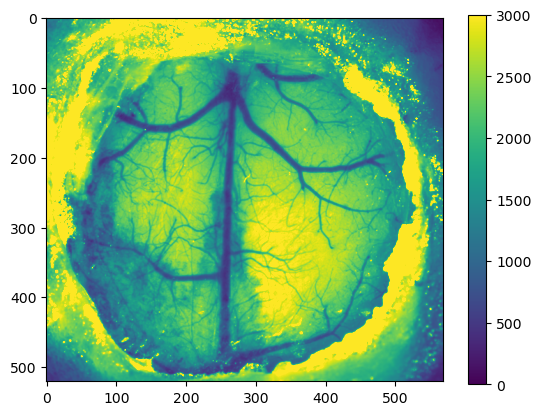

In [24]:
fig, ax = plt.subplots()
im = ax.imshow(mean_reflectance, vmin=0, vmax=3000)
cbar = fig.colorbar(im,ax=ax)

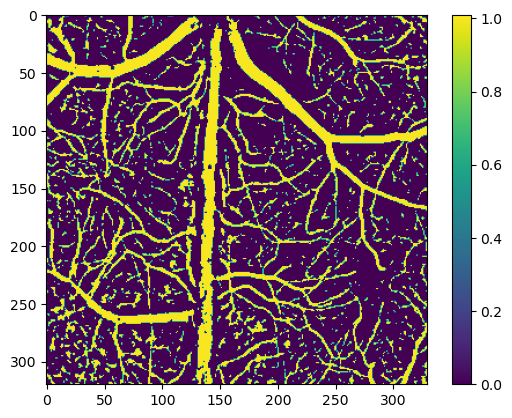

In [37]:
# Mouse and experiment CVR_31jan_M35

y_min = 110
y_max = 430
x_min = 120
x_max = 450

img1 = mean_reflectance[y_min:y_max, x_min:x_max]
thresholds = threshold_local(img1 , 21, offset=80, method='gaussian')
mask = img1 < thresholds
plt.imshow(img1 < thresholds, vmin=0, vmax=1.01)
plt.colorbar()
plt.show()

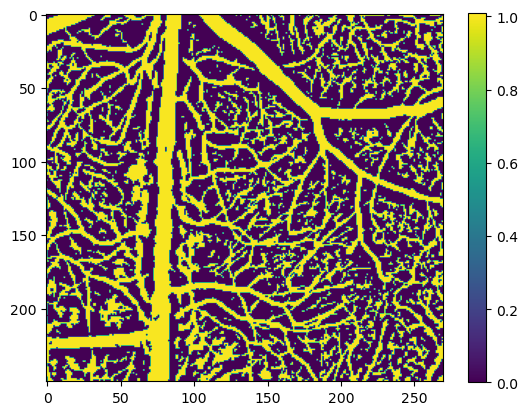

In [26]:
# Mouse and experiment CVR_31jan_M28
y_min = 150
y_max = 400
x_min = 180
x_max = 450

img1 = mean_reflectance[y_min:y_max, x_min:x_max]
thresholds = threshold_local(img1 , 21, offset=9, method='gaussian')
mask = img1 < thresholds
plt.imshow(img1 < thresholds, vmin=0, vmax=1.01)
plt.colorbar()
plt.show()

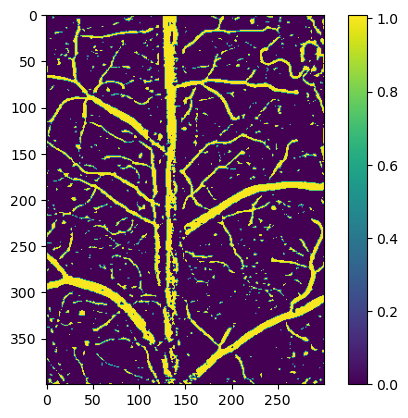

In [27]:
# For CVR_21fev_M35

y_min = 100
y_max = 500
x_min = 100
x_max = 400

img = tifffile.imread('/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_21fev/Correction/capillaries.tif')
img1 = img[y_min:y_max, x_min:x_max]
thresholds = threshold_local(img1 , 21, offset=6, method='gaussian')
mask = img1 < thresholds
plt.imshow(img1 < thresholds, vmin=0, vmax=1.01)
plt.colorbar()
plt.show()

## Function that outputs density of a plot

In [38]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter 

def compute_density(x, y, sigma=5, array_shape=(1000, 1000)):
    x_norm = x - np.min(x)
    x_norm /= np.max(x_norm)
    y_norm = y - np.min(y)
    y_norm /= np.max(y_norm)
    density = np.zeros(array_shape)
    for i, j in zip(x_norm, y_norm):
        density[int(j * array_shape[0] - 1), int(i * array_shape[1] - 1)] += 1
    density = gaussian_filter(density, sigma=sigma)
    density_values = []
    for i, j in zip(x_norm, y_norm):
        density_values.append(density[int(j * array_shape[0] - 1), int(i * array_shape[1] - 1)])
    return np.array(density_values)

In [39]:
min_window = min_matrix[y_min:y_max, x_min:x_max]
max_window = max_matrix[y_min:y_max, x_min:x_max]
min_window_only_capillaries = min_window[mask]
max_window_only_capillaries = max_window[mask]

min_windowflat = min_window_only_capillaries.flatten()
max_windowflat = max_window_only_capillaries.flatten()

In [40]:
def mask_coordinates(img, mask):
    true_vector = img[mask]
    coord_vector = np.zeros((2,true_vector.shape[0]))
    pixel_number = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j]:
                coord_vector[0][pixel_number] = i
                coord_vector[1][pixel_number] = j
                pixel_number += 1
    return coord_vector

In [41]:
# coordinates is a list of (x, y) coordinates of every pixel in the mask
coordinates = mask_coordinates(max_window, mask)

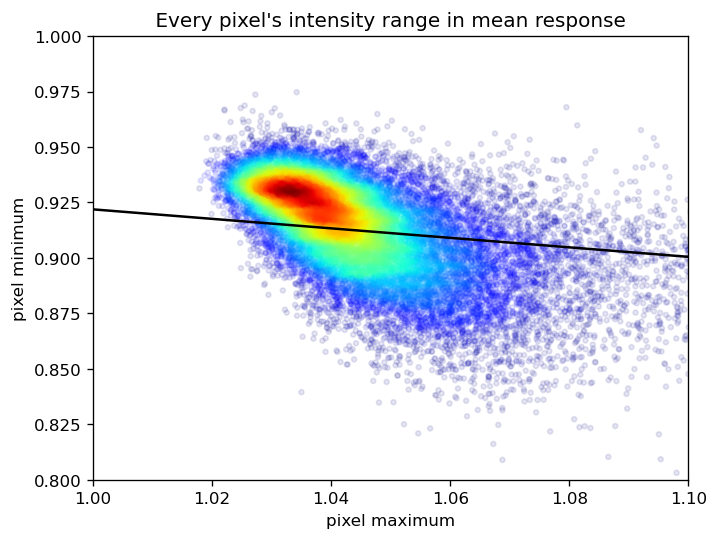

In [42]:
%matplotlib inline

max_windowflat.reshape(-1,1)
min_windowflat.reshape(-1,1)


# ----------------------------
# REGRESSION:  
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(max_windowflat.reshape(-1,1), min_windowflat.reshape(-1,1))
x_new = np.linspace(0.95, 2.4, 100)
y_new = model.predict(x_new[:, np.newaxis])
# ----------------------------


# To add in plt.scatter if density is needed: " c=density, cmap='jet' "
density = compute_density(max_windowflat, min_windowflat)
plt.figure(dpi=120)
plt.scatter(max_windowflat, min_windowflat, alpha=0.1, marker='.', c=density, cmap='jet')
plt.plot(x_new, y_new, 'k-')
plt.xlim([1,1.1])
plt.ylim([0.8,1])
plt.ylabel('pixel minimum')
plt.xlabel('pixel maximum')
plt.title(''' Every pixel's intensity range in mean response ''')
plt.show()

## Let's isolate horizontal and vertical clusters to try and dissociate vessel types

In [43]:
def vessel_clusters(mins, maxs, coords, minlim = None, maxlim = None):
    
    if mins.ndim > 1:
        mins = mins.flatten()
    if maxs.ndim > 1:
        maxs = maxs.flatten()
    
    if minlim == None:
        minlim = (min(minimums), max(minimums))
    if maxlim == None:
        maxlim = (min(maximums), max(maximums))
        
    cluster = []
    
    for i in range(len(mins)):
        if mins[i] > minlim[0] and mins[i] < minlim[1]:
            if maxs[i] > maxlim[0] and maxs[i] < maxlim[1]:
                cluster.append(coords[:,i])
    
    cluster = np.array(cluster).T
    return cluster

In [44]:
cluster_min = vessel_clusters(min_window_only_capillaries, max_window_only_capillaries, coordinates, minlim = (0.8,1.0), maxlim = (1.0, 1.03))
cluster_max = vessel_clusters(min_window_only_capillaries, max_window_only_capillaries, coordinates, minlim = (0.8,1.0), maxlim = (1.03, 1.3))

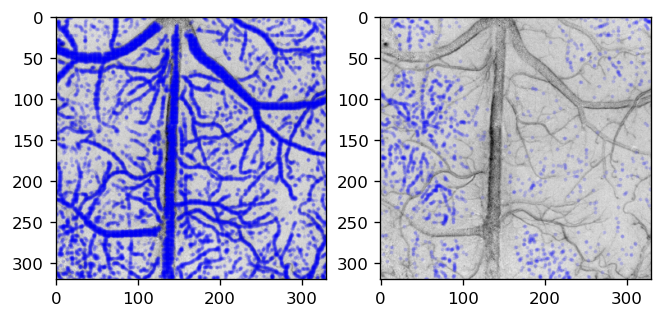

In [45]:
fig,ax = plt.subplots(1,2, dpi=120)
ax[0].imshow(min_window, cmap="gray")
ax[0].scatter(cluster_max[1], cluster_max[0], s=2, c='b', marker='o', alpha=0.1)
ax[1].imshow(min_window, cmap="gray")
ax[1].scatter(cluster_min[1], cluster_min[0], s=2, c='b', marker='o', alpha=0.1)
plt.show()

## PCA

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=10)
pat = timeseries
pca.fit(pat)

PCA(n_components=10)

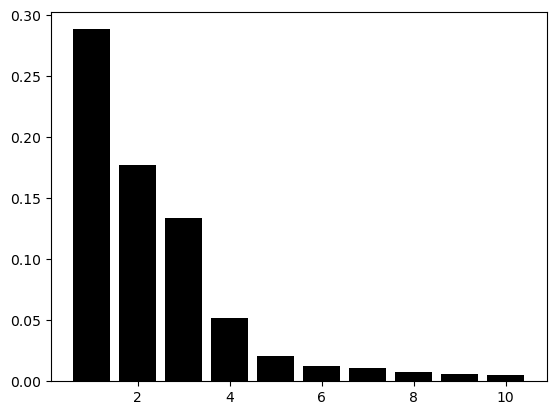

In [48]:
%matplotlib inline
EVR = np.array(pca.explained_variance_ratio_)
plt.bar(np.linspace(1,10,10), EVR, color='k')
plt.show()

In [49]:
first_component = pca.components_[0]
second_component = pca.components_[1]
third_component = pca.components_[2]
fourth_component = pca.components_[3]

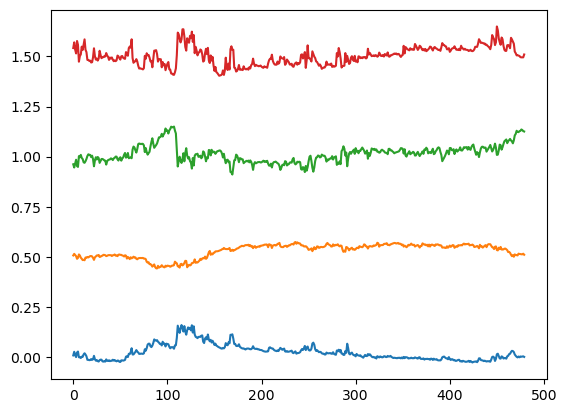

In [50]:
plt.plot(first_component)
plt.plot(second_component+0.5)
plt.plot(third_component+1) 
plt.plot(fourth_component+1.5)
plt.show()

In [51]:
transformed_timeseries = pca.transform(pat)

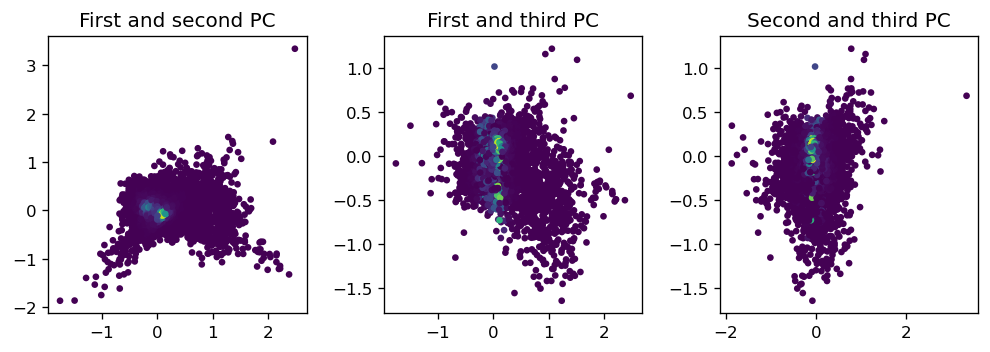

In [52]:
density_pca = compute_density(transformed_timeseries[::10, 0], transformed_timeseries[::10, 1])
fig, ax = plt.subplots(1, 3, dpi=120, figsize=(10, 3))

ax[0].scatter(transformed_timeseries[::10, 0], transformed_timeseries[::10, 1], marker='.', c=density_pca)
ax[0].set_title('First and second PC')
ax[0].set_aspect('auto', adjustable='box')

ax[1].scatter(transformed_timeseries[::10, 0], transformed_timeseries[::10, 2], marker='.', c=density_pca)
ax[1].set_title('First and third PC')
ax[1].set_aspect('auto', adjustable='box')

ax[2].scatter(transformed_timeseries[::10, 1], transformed_timeseries[::10, 2], marker='.', c=density_pca)
ax[2].set_title('Second and third PC')
ax[2].set_aspect('auto', adjustable='box')

fig.subplots_adjust(wspace=0.3)
plt.show()

In [53]:
%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

x = transformed_timeseries[::100, 1]
y = transformed_timeseries[::100, 2]
z = transformed_timeseries[::100, 3]

# create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# create scatter plot
ax.scatter(x, y, z, c='r', marker='o')


# set axis labels
ax.set_xlabel('PC2 Label')
ax.set_ylabel('PC3 Label')
ax.set_zlabel('PC4 Label')

# define animation function
#def update(frame):
#    ax.view_init(elev=10., azim=frame)
#    return scatter,

# create animation
#anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=500)

# show plot
plt.show()

# Now for HbT

In [4]:
lights = create_movies(folderpath, channels = ['red', 'green'], channels_exist = True, stim_path = True)

data_path: /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M35
stim_path: True
channels: ['red', 'green']
channels_exist: True
binning: False
normalize: False
gaussian_filter: False
gaussian_std: 1
temp_med_filter: False
temp_med_width: 3
substract_background: False
background_path: None


In [9]:
red, green = lights[0].data , lights[1].data

In [22]:
# Change directory to parent directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
os.chdir(parent_directory)

In [23]:
HbO, HbR = convert_to_hb(green, red)

In [24]:
os.chdir(current_directory)

In [28]:
HbT = HbO + HbR

In [38]:
HbT.max()

-0.001059523214308159

In [57]:
%matplotlib qt

# Animate the frames
anim = animate_frames(HbR, lights[0].freq*3, -0.0015, -0.0010)

# Display the animation
plt.show()

## The rest is history ! 
## Now, under there is a bunch of stuff I've worked on that got to MIFFE.py or that helped the upper steps.

In [49]:
%matplotlib qt

animate_2d_array(average_response_frames)

NameError: name 'animate_2d_array' is not defined

In [16]:
%matplotlib qt

timeseries = movie.get_timeseries()

Click on the figure to create a polygon.
Hold the 'shift' key to move all of the vertices.
Hold the 'ctrl' key to move a single vertex.


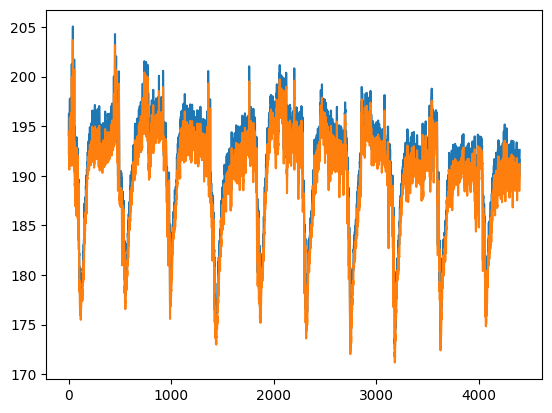

In [18]:
%matplotlib inline

plt.plot(average_response_frames)
plt.plot(timeseries)
plt.show()

## Files and folders, paths and names. 

In [4]:
def generate_data_folder(movie, folderpath, tif=False, CaImAn=False, numpy=False):
    #Creates a folder in which movie is transformed to 
    
    Correction_folder_name = 'Correction'
    newfolderpath = "".join([folderpath,  '/', Correction_folder_name])
    if not os.path.exists(newfolderpath):
        os.makedirs(newfolderpath)
    
    if tif:
        path = os.path.normpath(folderpath)
        pathlist = path.split(os.sep)
        filename = "".join([pathlist[-1], "_", channel[0], '_movie', '.tif'])
        filepath = Path(newfolderpath) / Path(filename)
        movie.convert_to_tif(filepath, convert16=True)
    
    if CaImAn:
        parameters = get_wf_mc_params()
        CaImAn_folder_path = newfolderpath + '/'
        correct_motion_directory(CaImAn_folder_path, parameters, keywords=['.tif'])
        
    if numpy:
        npyfilename = Path("".join(['corrected_', pathlist[-1], "_", channel[0], '_movie', '.npy']))
        newnpypath = newfolderpath / npyfilename
        corrected_tif_filename = "".join(['corrected_', filename])
        corrected_tif_path = data_path / newfolderpath / corrected_tif_filename
        imageio_array = imageio.imread(corrected_tif_path)
        nparray = np.array(imageio_array, dtype=np.float32)
        np.save(newnpypath, nparray)
        
    if tif and CaImAn and numpy:
        movie_npy = np.load(newnpypath)
        return movie_npy

### Creates a "Correction" folder

In [22]:
Correction_folder_name = 'Correction'
newfolderpath = "".join([folderpath,  '/', Correction_folder_name])
if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)

/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_28fev/Correction


### Creates a .tif from self.data (movie) object of WFMovie class. Puts the .tif file in the "Correction" folder

In [24]:
#%% Saving movie in file

path = os.path.normpath(folderpath)
pathlist = path.split(os.sep)
filename = "".join([pathlist[-1], "_", channel[0], '_movie', '.tif'])
filepath = Path(newfolderpath) / Path(filename)
movie.convert_to_tif(filepath, convert16=True)

## CaImAn motion correction on .tif file

In [13]:
parameters = get_wf_mc_params()
CaImAn_folder_path = newfolderpath + '/'
correct_motion_directory(CaImAn_folder_path, parameters, keywords=['.tif'])

Searching directory for uncorrected data in /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34/Correction/...
Calcium imaging data to correct: ['CVR_31jan_M34_green_movie.tif', 'CVR_31jan_M34_red_movie.tif']
Beginning motion correction...
Correcting CVR_31jan_M34_green_movie.tif...


2023-02-06 16:56:26.523096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 16:56:26.523799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 16:56:26.523822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34/Correction/CVR_31jan_M34_green_movie_els__d1_521_d2_569_d3_1_order_F_frames_4000.mmap


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


Correcting CVR_31jan_M34_red_movie.tif...


2023-02-06 17:02:41.181377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:02:41.181785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:02:41.181768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34/Correction/CVR_31jan_M34_red_movie_els__d1_521_d2_569_d3_1_order_F_frames_4000.mmap


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


Done!


## Return to .npy for normalization and data measures

In [18]:
npyfilename = Path("".join(['corrected_', pathlist[-1], "_", channel[0], '_movie', '.npy']))
newnpypath = newfolderpath / npyfilename
corrected_tif_filename = "".join(['corrected_', filename])
corrected_tif_path = data_path / newfolderpath / corrected_tif_filename
imageio_array = imageio.imread(corrected_tif_path)
nparray = np.array(imageio_array, dtype=np.float32)
np.save(newnpypath, nparray)

## Updates self.data with "convert_matrix_to_movie"

In [4]:
# Uncomment if green is not hardcoded
#green = search_path(path_type='file')
green = "/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34/Correction/corrected_CVR_31jan_M34_green_movie.npy"
green_movie = np.load(green)

In [6]:
movie.data = green_movie

## Normalize by mean of image

In [7]:
movie.normalize_by_mean()

In [76]:
matplotlib qt

## Outputs normalized map in plt.show()

In [31]:
#uses the 'notebook' backend of matplotlib to display stuff. the backend "qt" fucks with PyQT5 package used for search_path() function.

fig, ax = plt.subplots()
vmin = 0.97
vmax = 1.03
framerate=1000/movie.freq #le arg "interval" est en ms
def animate(i):
    ax.clear()
    plt.axis('off')
    ax.imshow(movie.data[i,:,:],vmin=vmin,vmax=vmax)
im = ax.imshow(movie.data[0],vmin=vmin,vmax=vmax)
cb = plt.colorbar(im)
anim = animation.FuncAnimation(fig, animate,frames=movie.nframes,interval=framerate)
plt.show()

#peut-être mieux %matplotlib qt pour avoir un framerate plus défini.

# Trials to output time series

In [4]:
channel = "green"
folderpath="/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34"
stim_path = Path("/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M34/CVR_31jan_M34-stim_signal.npy")
data_path = Path(folderpath)
movie = WFmovie(data_path,channel)

In [9]:
stim_path = Path(path_type='file')

In [10]:
search_path(path_type='file')

You chose: /Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_21fev/CVR_M35_21fev-stim_signal.npy


'/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M35_21fev/CVR_M35_21fev-stim_signal.npy'

In [4]:
movie.normalize_by_mean()

In [5]:
%matplotlib qt

roi = movie.create_mask()
mean_timeseries = movie.get_timeseries(roi)

%matplotlib inline

Click on the figure to create a polygon.
Hold the 'shift' key to move all of the vertices.
Hold the 'ctrl' key to move a single vertex.


In [6]:
%matplotlib qt

roi = movie.create_mask()
background = movie.get_timeseries(roi)

%matplotlib inline

Click on the figure to create a polygon.
Hold the 'shift' key to move all of the vertices.
Hold the 'ctrl' key to move a single vertex.


In [7]:
%matplotlib qt

plt.plot(background)
plt.plot(mean_timeseries)
plt.plot()
ax = plt.gca()
ax.set_ylim((160,190))
plt.show()

In [20]:
reg = regress_timeseries(mean_timeseries, background)

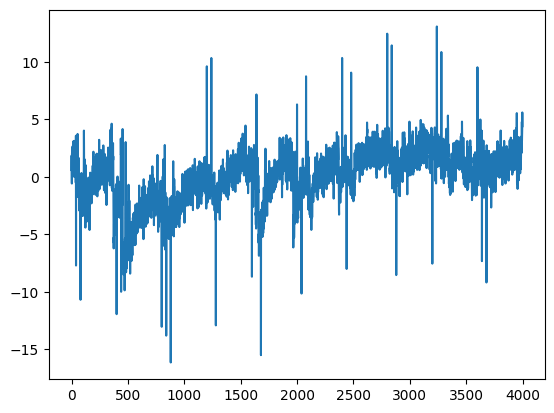

In [21]:
plt.plot(reg)

In [ ]:
signal = search_path(path_type='file')
stim = np.load(signal)
stim = stim[0]
print(stim.shape)
print(movie.data.shape)
resampled_stim = []
for i in range (stim.shape[0]):
    if i%750 == 1:
        resampled_stim.append(stim[i-750])


In [23]:
plotstim = np.array(resampled_stim)/30 + 0.8

In [28]:
%matplotlib qt
plt.plot(mean_timeseries)
#plt.plot(mean_timeseries2)
plt.plot(plotstim)
plt.show()

In [16]:
binary_stim = (np.array(resampled_stim) != 0).astype('int')

In [17]:
onsets = []
for i in range(len(binary_stim) - 1):
    if (binary_stim[i] == 0) and (binary_stim[i+1] == 1):
        onsets.append(i)

In [18]:
onsets

[40, 440, 840, 1240, 1640, 2040, 2440, 2840, 3240, 3640]

In [19]:
from scipy.stats import zscore

In [19]:
trials = []
for onset in onsets:
    trials.append(mean_timeseries[onset-20:onset + 250])

In [20]:
trials_z = []
for trial in trials:
    trials_z.append(zscore(trial))

In [21]:
trial_average = np.mean(np.stack(trials_z, axis=0), axis=0)

In [27]:
plt.plot(background)

In [24]:
regressed =  trial_average - background

In [25]:
plt.plot(regressed)
plt.show()

In [23]:
plt.plot(trial_average, color='red', zorder=10)
for trial in trials_z:
    plt.plot(trial, color='black', alpha=0.25)
plt.show()

In [71]:
%matplotlib inline

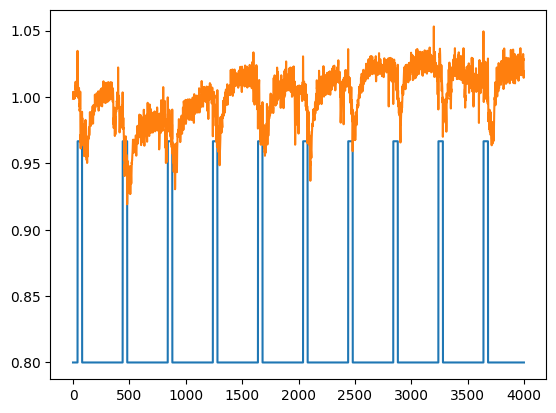

In [75]:
#plt.plot(plotstim)
plt.plot(mean_timeseries)

In [5]:
%matplotlib qt

roi = movie.create_mask()
background = movie.get_timeseries(roi)

%matplotlib inline

Click on the figure to create a polygon.
Hold the 'shift' key to move all of the vertices.
Hold the 'ctrl' key to move a single vertex.


In [7]:
plt.plot(mean_timeseries)
plt.plot(background)
plt.show()

In [12]:
reg = regress_timeseries(mean_timeseries, background)
mean_timeseries = reg

In [11]:
plt.plot(reg)
plt.show()

In [12]:
%matplotlib qt

roi = movie.create_mask()
mean_timeseries = movie.get_timeseries(roi)

Click on the figure to create a polygon.
Hold the 'shift' key to move all of the vertices.
Hold the 'ctrl' key to move a single vertex.


In [13]:
onsets = []
for i in range(len(binary_stim) - 1):
    if (binary_stim[i] == 0) and (binary_stim[i+1] == 1):
        onsets.append(i)

NameError: name 'binary_stim' is not defined

In [15]:
trials = []
for onset in onsets:
    trials.append(mean_timeseries[onset-20:onset + 250])

In [16]:
trials_background = []
for onset in onsets:
    trials_background.append(background[onset-20:onset + 250])

In [17]:
trials_z, trials_background_z = [], []
for trial, trial_b in zip(trials, trials_background):
    trials_z.append(zscore(trial))
    trials_background_z.append(zscore(trial_b))

In [18]:
trials_sub = np.stack(trials_z, axis=0) - np.stack(trials_background_z, axis=0)

In [4]:
# Function that could do what is done in the loop below but within a grid of 2 by 5 plots 

def create_subplots(arr):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        if i < len(arr):
            ax.plot(np.arange(len(arr[i])), arr[i])
    plt.tight_layout()
    plt.show()

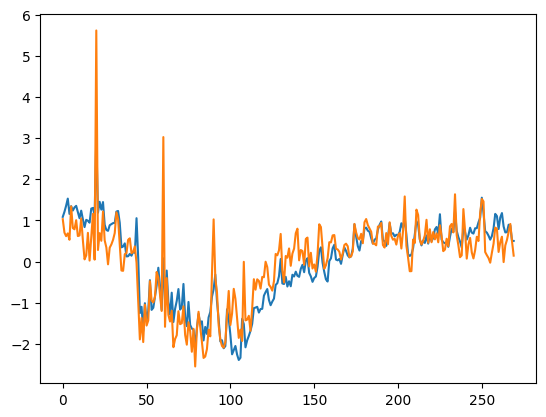

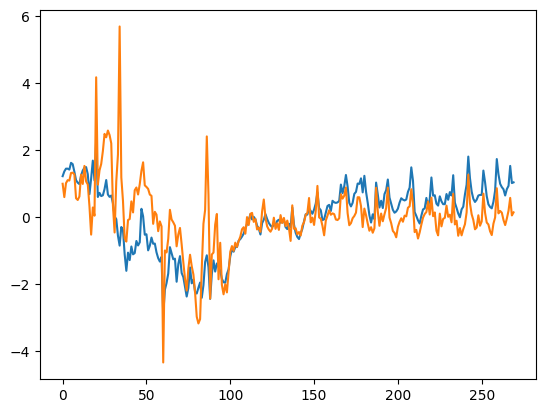

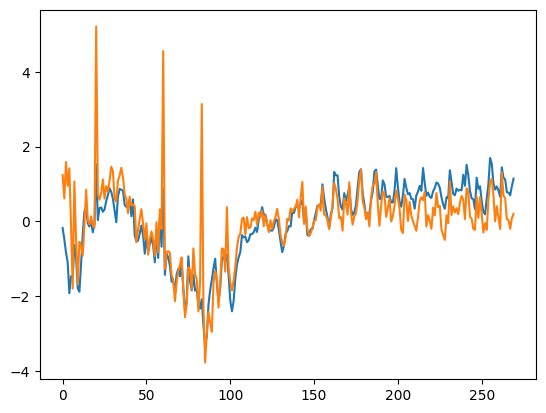

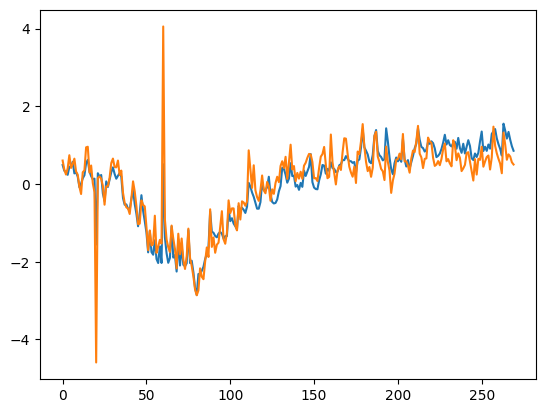

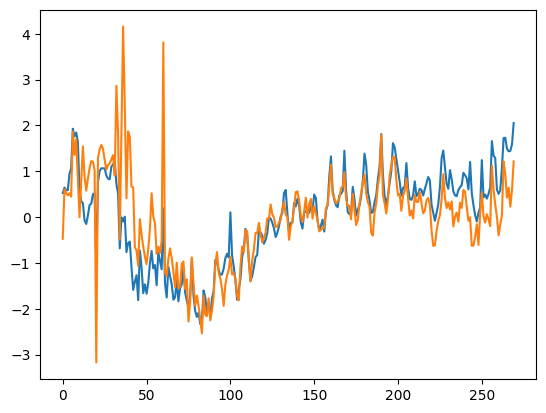

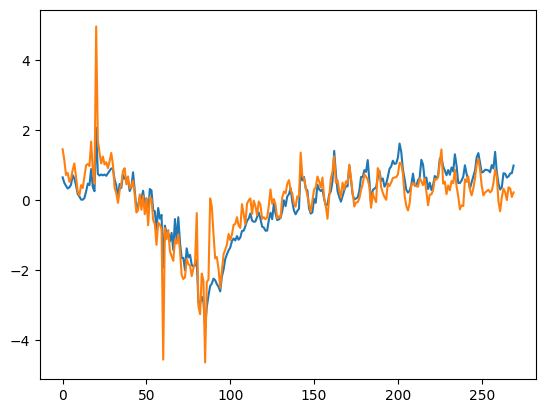

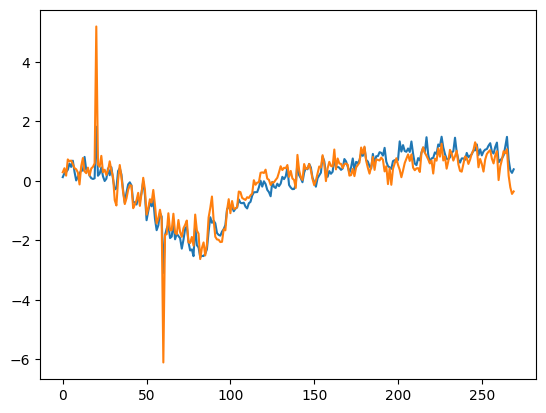

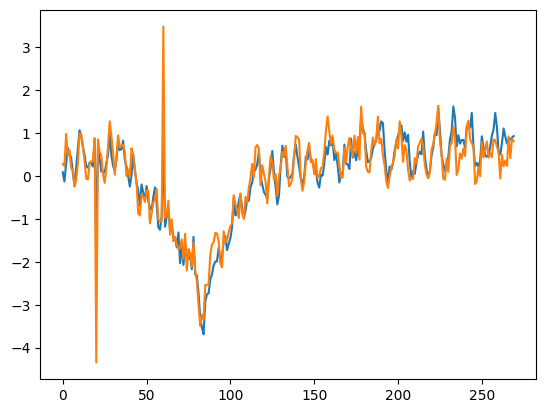

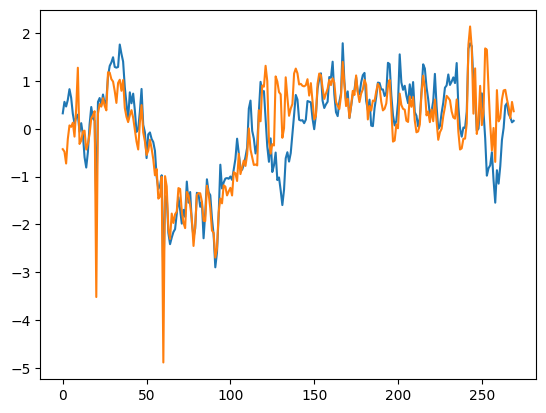

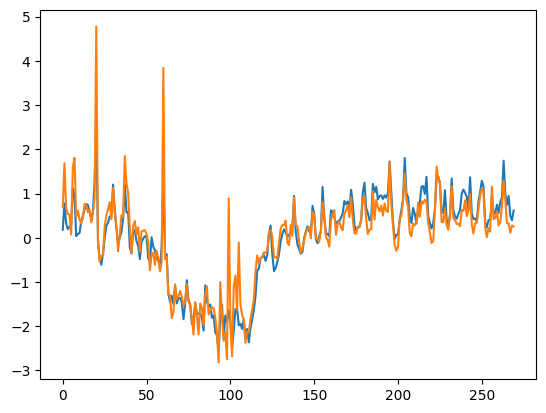

In [19]:
for i in range(10):
    plt.plot(trials_z[i])
    plt.plot(trials_background_z[i])
    plt.show()

In [21]:
trial_average = np.mean(np.stack(trials_z, axis=0), axis=0)
trial_average_background = np.mean(np.stack(trials_background_z, axis=0), axis=0)
trial_average_sub = np.mean(trials_sub, axis=0)

In [22]:
from scipy.stats import zscore

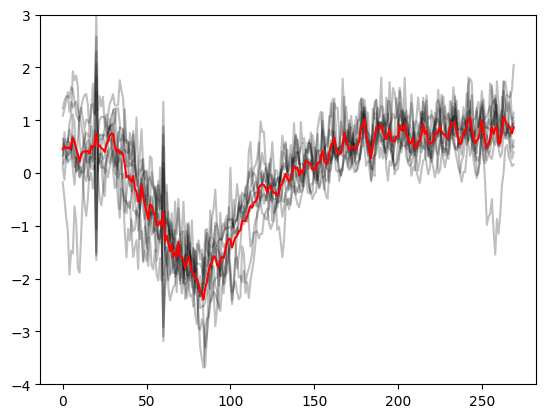

In [25]:
plt.plot(trial_average, color='red', zorder=10)
for trial in trials_z:
    plt.plot(trial, color='black', alpha=0.25)
ax = plt.gca()
ax.set_ylim([-4, 3])
plt.show()

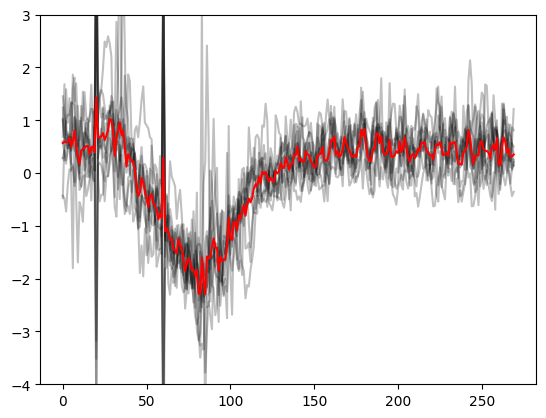

In [26]:
plt.plot(trial_average_background, color='red', zorder=10)
for trial in trials_background_z:
    plt.plot(trial, color='black', alpha=0.25)
ax = plt.gca()
ax.set_ylim([-4, 3])
plt.show()

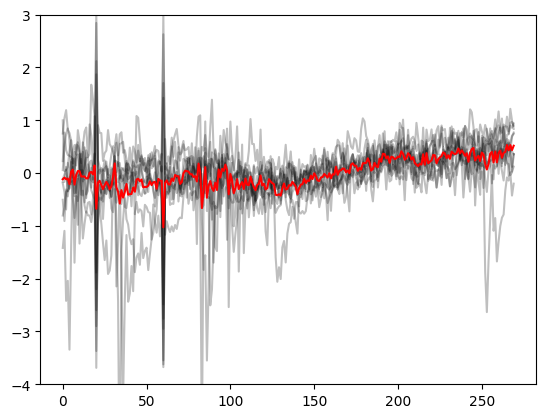

In [27]:
plt.plot(trial_average_sub, color='red', zorder=10)
for trial in trials_sub:
    plt.plot(trial, color='black', alpha=0.25)
ax = plt.gca()
ax.set_ylim([-4, 3])
plt.show()

In [30]:
from scipy.stats import ttest_ind

In [31]:
trials_sub.shape

(10, 270)

In [67]:
x1 = trials_sub[:, 65]
x2 = trials_sub[:, 200]

In [68]:
x1 = x1.flatten()

In [69]:
x2 = x2.flatten()

In [70]:
ttest_ind(x1, x2)

Ttest_indResult(statistic=-2.293300092827783, pvalue=0.03408701574826258)

In [3]:
reg = regress_timeseries(trial_average, trial_average_background)

NameError: name 'trial_average' is not defined